In [1]:
pip install julian

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
import json
from datetime import datetime
import julian
import datetime
import scipy as scp
from scipy import stats
import math

In [3]:
# Load CA Temp Data csv file
AvgTemp_CA_csv = "CA_Temps_2007_2018.csv"

# Convert to dataframe and sort by year and month
AvgTemp_CA = pd.read_csv(AvgTemp_CA_csv)
AvgTemp_CA.sort_values(by=["YEAR", "MONTH"], inplace=True, ascending=True)
AvgTemp_CA.head()

,MONTH,YEAR,AVG_TEMP,AVG_HIGHS,MAX_TEMP,PRECIPITATION,Unnamed: 6
0,1,2007,33.4,58.9,69.1,0.06,
1,2,2007,53.1,63.5,77.0,3.42,NaN
2,3,2007,61.0,75.2,84.9,0.07,NaN
3,4,2007,63.0,77.0,91.9,1.66,NaN
4,5,2007,70.9,87.5,98.1,0.30,NaN


In [4]:
# Connect to database
conn = sqlite3.connect("FPA_FOD_20170508.sqlite")
fires = pd.read_sql_query("SELECT * FROM fires", conn)

In [5]:
# Convert from julian to calendar dates
fires["START_DATE"] = pd.to_datetime(fires["DISCOVERY_DATE"] - pd.Timestamp(0).to_julian_date(), unit='D')
fires["END_DATE"] = pd.to_datetime(fires["CONT_DATE"] - pd.Timestamp(0).to_julian_date(), unit='D')

# Drop unnecessary columns with drop function
fires.drop(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'STAT_CAUSE_CODE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE_CLASS', 
       'OWNER_CODE', 'FIPS_CODE', 'FIPS_NAME', 'Shape'], axis=1, inplace=True)

# Sort by start date
fires.sort_values(by=["START_DATE"], inplace=True, ascending=False)

#Filter by State to CA only
fires.drop(fires[fires.STATE != "CA"].index, inplace=True)
fires.head()

,SOURCE_REPORTING_UNIT_NAME,FIRE_NAME,FIRE_YEAR,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,START_DATE,END_DATE
1872288,Nevada-Yuba-Placer Unit,RODEO,2015,Arson,0.01,39.173027,-121.057377,MISSING/NOT SPECIFIED,CA,NEVADA,2015-12-31,2015-12-31
1871985,CDF - Monte Vista Unit,LEIGH,2015,Missing/Undefined,0.10,32.701123,-117.007382,MISSING/NOT SPECIFIED,CA,SAN DIEGO,2015-12-31,NaT
1871977,CDF - Fresno-Kings Unit,ACADEMY 2,2015,Debris Burning,0.10,36.536611,-119.556721,MISSING/NOT SPECIFIED,CA,FRESNO,2015-12-31,NaT
1872285,Santa Barbara County Fire Department,None,2015,Missing/Undefined,0.01,35.050000,-120.166666,MISSING/NOT SPECIFIED,CA,SANTA BARBARA,2015-12-31,NaT
1872147,CDF - Riverside Unit,PINON,2015,Miscellaneous,0.10,33.808482,-117.358313,MISSING/NOT SPECIFIED,CA,RIVERSIDE,2015-12-30,2015-12-30


# Temperature Data: Average Annual Temperatures in CA
## Obtained average annual temperatures in CA from 2007-2018
### Source: https://www.usclimatedata.com/climate/winters/california/united-states/usca1252/2007/1

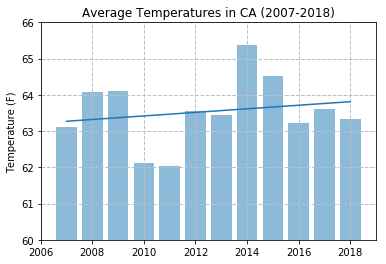

In [7]:
# Group by year
by_year = AvgTemp_CA.groupby(["YEAR"])

# Calculate average temperature by year
avg_temp = by_year["AVG_TEMP"].mean().reset_index()

# Create variables for graph of average temperatures in CA (2007-2018)
x = avg_temp["YEAR"]
y = avg_temp["AVG_TEMP"]

# Add trendline
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(x,y)
y_hat = x * slope + intercept

# Set y-axis limits
plt.ylim([math.ceil(60), math.ceil(66)])

# Graph average temperatures by year
plt.bar(x, y, align= "center", alpha=0.5)
plt.plot(x,y_hat)
plt.grid(True, lw = 1, ls = '--', c = '.75')

plt.ylabel("Temperature (F)")
plt.title("Average Temperatures in CA (2007-2018)")

plt.show()

# Fire Data: Number of Fires and Acres Burned Annually
## Obtained historical wildfire data from 1992-2018
### Source (1992-2015): https://www.kaggle.com/rtatman/188-million-us-wildfires
### Source (2015-2018): https://en.wikipedia.org/wiki/2018_California_wildfires

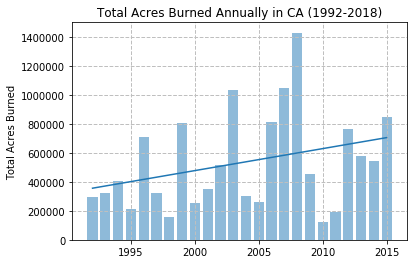

In [8]:
# Group by year
by_year = fires.groupby(["FIRE_YEAR"])

# Sum total acres burned by year
total_acres = by_year["FIRE_SIZE"].sum().reset_index()

# Create variables for graph of number of acres burned by year
x = total_acres["FIRE_YEAR"]
y = total_acres["FIRE_SIZE"]

# Add trendline
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(x,y)
y_hat = x * slope + intercept

# Graph number of acres burned by year
plt.bar(x, y, align= "center", alpha=0.5)
plt.plot(x,y_hat)
plt.grid(True, lw = 1, ls = '--', c = '.75')

plt.ylabel("Total Acres Burned")
plt.title("Total Acres Burned Annually in CA (1992-2018)")

plt.show()

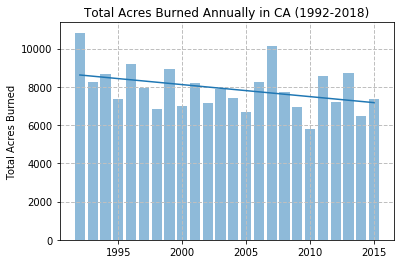

In [9]:
# Sum total fires by year
total_fires = by_year["FIRE_SIZE"].count().reset_index()

# Create variables for graph of number of fires by year
x = total_fires["FIRE_YEAR"]
y = total_fires["FIRE_SIZE"]

# Add trendline
slope, intercept, r_value, p_value, std_err = scp.stats.linregress(x,y)
y_hat = x * slope + intercept

# Graph number of acres burned by year
plt.bar(x, y, align= "center", alpha=0.5)
plt.plot(x,y_hat)
plt.grid(True, lw = 1, ls = '--', c = '.75')

plt.ylabel("Total Acres Burned")
plt.title("Total Acres Burned Annually in CA (1992-2018)")

plt.show()